In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix, classification_report, log_loss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000, regularization=None, C=1.0):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.regularization = regularization
        self.C = C
        self.weights = None
        self.bias = None
        
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _initialize_weights(self, n_features):
        self.weights = np.zeros(n_features)
        self.bias = 0
    
    
    def _compute_gradients(self, X, y, y_hat):
        m = y.shape[0]
        dw = 1/m * np.dot(X.T, (y_hat - y))
        db = 1/m * np.sum(y_hat - y)
        if self.regularization == 'l2':
            dw += (self.C / m) * self.weights
        elif self.regularization == 'l1':
            dw += (self.C / m) * np.sign(self.weights)
        return dw, db
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._initialize_weights(n_features)
        
        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_hat = self._sigmoid(linear_model)
            
            dw, db = self._compute_gradients(X, y, y_hat)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)
    
    def predict(self, X):
        y_hat = self.predict_proba(X)
        return [1 if i > 0.46 else 0 for i in y_hat]
    
    def get_weights(self):
        return self.weights, self.bias

In [3]:
cust_df = pd.read_csv('dataset/customer_data.csv')

In [4]:
cust_df.shape

(1125, 13)

In [5]:
cust_df.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [6]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   1125 non-null   int64  
 1   id      1125 non-null   int64  
 2   fea_1   1125 non-null   int64  
 3   fea_2   976 non-null    float64
 4   fea_3   1125 non-null   int64  
 5   fea_4   1125 non-null   float64
 6   fea_5   1125 non-null   int64  
 7   fea_6   1125 non-null   int64  
 8   fea_7   1125 non-null   int64  
 9   fea_8   1125 non-null   int64  
 10  fea_9   1125 non-null   int64  
 11  fea_10  1125 non-null   int64  
 12  fea_11  1125 non-null   float64
dtypes: float64(3), int64(10)
memory usage: 114.4 KB


In [7]:
cust_df.describe().round()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
count,1125.0,1125.0,1125.0,976.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0
mean,0.0,57836771.0,5.0,1284.0,2.0,120884.0,2.0,11.0,5.0,101.0,4.0,164618.0,135.0
std,0.0,1817150.0,1.0,52.0,1.0,88445.0,0.0,3.0,3.0,12.0,1.0,152520.0,113.0
min,0.0,54982353.0,1.0,1116.0,1.0,15000.0,1.0,3.0,-1.0,64.0,1.0,60000.0,1.0
25%,0.0,54990497.0,4.0,1244.0,1.0,72000.0,2.0,8.0,5.0,90.0,3.0,60044.0,1.0
50%,0.0,58989748.0,5.0,1282.0,3.0,102000.0,2.0,11.0,5.0,105.0,4.0,72000.0,173.0
75%,0.0,58997994.0,7.0,1314.0,3.0,139000.0,2.0,11.0,5.0,111.0,5.0,151307.0,202.0
max,1.0,59006239.0,7.0,1481.0,3.0,1200000.0,2.0,16.0,10.0,115.0,5.0,650070.0,707.0


<Axes: xlabel='label', ylabel='count'>

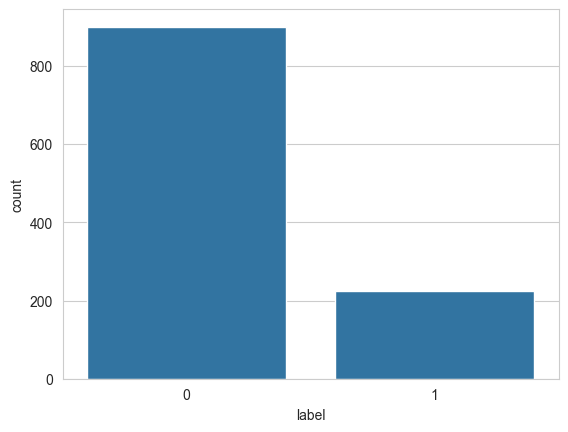

In [8]:
sns.set_style("whitegrid")
sns.countplot(x = "label", data = cust_df)

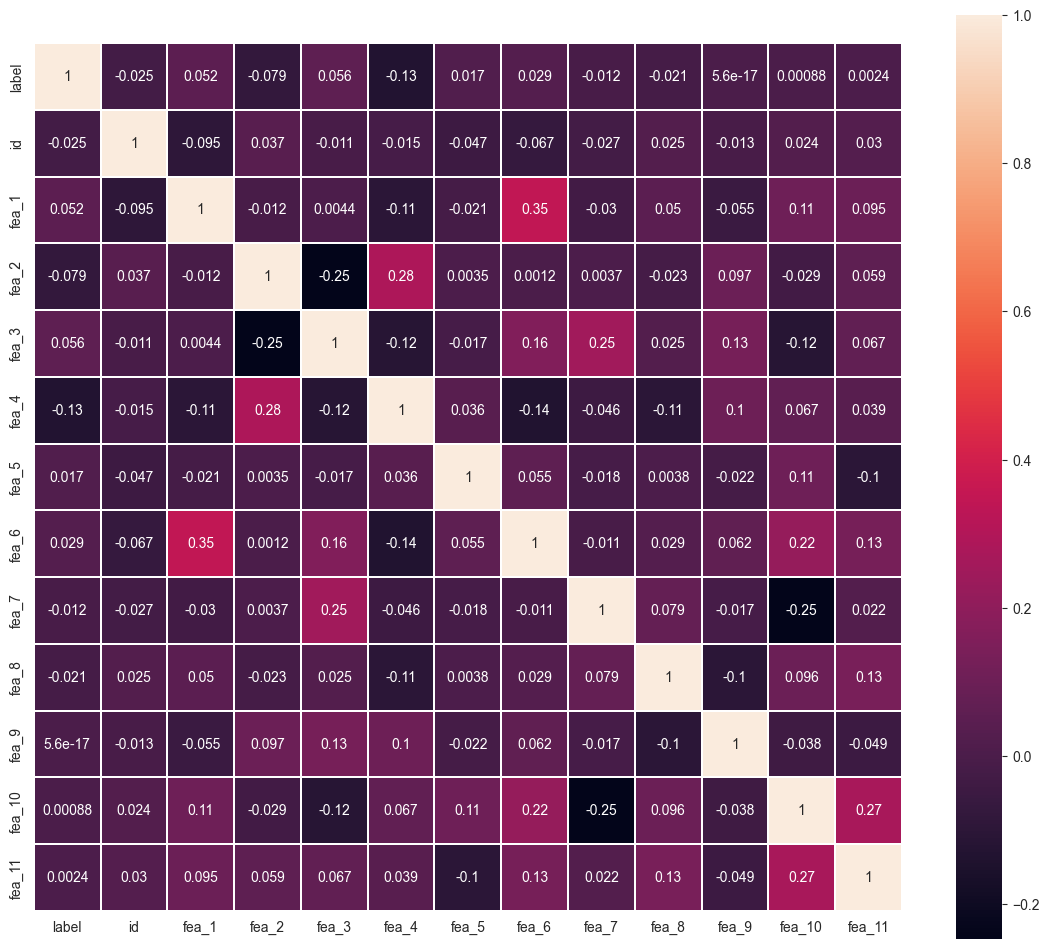

In [9]:
plt.figure(figsize=(14,12))
sns.heatmap(cust_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

In [10]:
from sklearn.impute import SimpleImputer

imputer =  SimpleImputer(strategy="median")
cust_df= pd.DataFrame(imputer.fit_transform(cust_df), columns = cust_df.columns)

In [11]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   1125 non-null   float64
 1   id      1125 non-null   float64
 2   fea_1   1125 non-null   float64
 3   fea_2   1125 non-null   float64
 4   fea_3   1125 non-null   float64
 5   fea_4   1125 non-null   float64
 6   fea_5   1125 non-null   float64
 7   fea_6   1125 non-null   float64
 8   fea_7   1125 non-null   float64
 9   fea_8   1125 non-null   float64
 10  fea_9   1125 non-null   float64
 11  fea_10  1125 non-null   float64
 12  fea_11  1125 non-null   float64
dtypes: float64(13)
memory usage: 114.4 KB


In [12]:
X = cust_df.drop("label", axis=1)
y = cust_df["label"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [14]:
logreg = Pipeline(steps=[
    ('scaler', StandardScaler()),  
    ('smote', SMOTE(sampling_strategy="minority", random_state=27)),  
    ('logreg', LogisticRegression(learning_rate=0.01, n_iter=1000, regularization='l2', C=1.0))
])

In [15]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}\n")

              precision    recall  f1-score   support

         0.0       0.87      0.43      0.58       174
         1.0       0.29      0.78      0.42        51

    accuracy                           0.51       225
   macro avg       0.58      0.61      0.50       225
weighted avg       0.74      0.51      0.54       225

Confusion Matrix:
 [[75 99]
 [11 40]]



In [16]:
fpr, tpr, _  = roc_curve(y_test, y_pred_proba)
roc_auc_score = auc(fpr, tpr)

precision_score_value = precision_score(y_test, y_pred, zero_division=0)

recall_score_value = recall_score(y_test, y_pred, zero_division=0)

print(f"ROC AUC Score: {roc_auc_score:.4f}")
print(f"Precision: {precision_score_value:.4f}")
print(f"Recall: {recall_score_value:.4f}")

ROC AUC Score: 0.5906
Precision: 0.2878
Recall: 0.7843


In [17]:
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss: {logloss:.4f}")

Log Loss: 0.6822


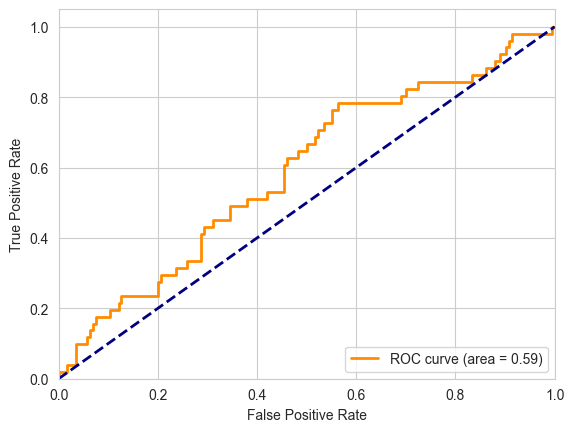

In [18]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

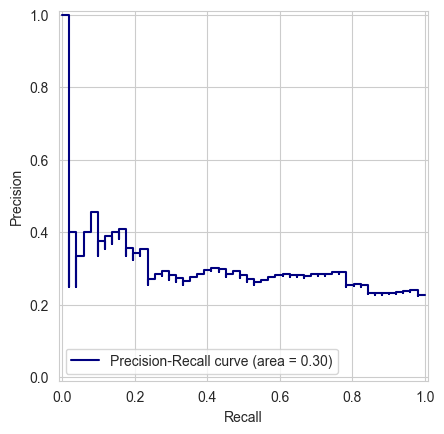

In [19]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, prec)
pr_curve = PrecisionRecallDisplay(precision=prec, recall=recall).plot(label=f'Precision-Recall curve (area = {pr_auc:.2f})', color='navy')